In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
X_test = np.load("data/X_test.npy")
X_train = np.load("data/X_train.npy")
y_test = np.load("data/y_test.npy")
y_train = np.load("data/y_train.npy")

In [3]:
print(f"Forme des données d'entraînement: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Forme des données de test: X_test {X_test.shape}, y_test {y_test.shape}")

print("Statistiques descriptives de y_train:")
print(f"Moyenne: {np.mean(y_train):.4f}")
print(f"Écart-type: {np.std(y_train):.4f}")
print(f"Min: {np.min(y_train):.4f}")
print(f"Max: {np.max(y_train):.4f}")

Forme des données d'entraînement: X_train (200, 200), y_train (200, 1)
Forme des données de test: X_test (200, 200), y_test (200, 1)
Statistiques descriptives de y_train:
Moyenne: 4.9068
Écart-type: 0.9454
Min: 1.9300
Max: 7.4648


In [4]:
def create_objective_function(model_type, X_train, y_train):
    """
    Crée une fonction objective pour Optuna selon le type de modèle
    """
    def objective(trial):
        if model_type == 'ridge':
            # Paramètres Ridge
            alpha = trial.suggest_float('alpha', 1e-4, 1e2, log=True)
            
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=alpha, random_state=42))
            ])
            
            
        elif model_type == 'elastic_net':
            # Paramètres ElasticNet
            alpha = trial.suggest_float('alpha', 1e-4, 1e1, log=True)
            l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)
            
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('elastic', ElasticNet(
                    alpha=alpha,
                    l1_ratio=l1_ratio,
                    random_state=42,
                    max_iter=2000
                ))
            ])
        
        # Validation croisée
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
        return cv_scores.mean()
    
    return objective

In [9]:
# Méthode 1: Ridge Regression avec Optuna
print("=== MÉTHODE 1: RIDGE REGRESSION (OPTUNA) ===")

# Optimisation avec Optuna
ridge_study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

ridge_objective = create_objective_function('ridge', X_train, y_train)
ridge_study.optimize(ridge_objective, n_trials=200)

# Entraînement du meilleur modèle
best_ridge_params = ridge_study.best_params
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_ridge_params['alpha'], random_state=42))
])

ridge_pipeline.fit(X_train, y_train)
ridge_pred = ridge_pipeline.predict(X_test)
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"Meilleurs hyperparamètres Ridge: {best_ridge_params}")
print(f"Score R² validation croisée: {ridge_study.best_value:.4f}")
print(f"Score R² sur test set: {ridge_r2:.4f}")
print(f"Nombre d'essais: {len(ridge_study.trials)}")


=== MÉTHODE 1: RIDGE REGRESSION (OPTUNA) ===
Meilleurs hyperparamètres Ridge: {'alpha': 10.449682770401537}
Score R² validation croisée: 0.5702
Score R² sur test set: 0.7146
Nombre d'essais: 200


In [7]:
print("\n=== MÉTHODE 4: ELASTICNET (OPTUNA) ===")

elastic_study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

elastic_objective = create_objective_function('elastic_net', X_train, y_train)
elastic_study.optimize(elastic_objective, n_trials=300)

# Entraînement du meilleur modèle
best_elastic_params = elastic_study.best_params
elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic', ElasticNet(
        alpha=best_elastic_params['alpha'],
        l1_ratio=best_elastic_params['l1_ratio'],
        random_state=42,
        max_iter=2000
    ))
])

elastic_pipeline.fit(X_train, y_train)
elastic_pred = elastic_pipeline.predict(X_test)
elastic_r2 = r2_score(y_test, elastic_pred)

print(f"Meilleurs hyperparamètres ElasticNet: {best_elastic_params}")
print(f"Score R² validation croisée: {elastic_study.best_value:.4f}")
print(f"Score R² sur test set: {elastic_r2:.4f}")
print(f"Nombre d'essais: {len(elastic_study.trials)}")


=== MÉTHODE 4: ELASTICNET (OPTUNA) ===
Meilleurs hyperparamètres ElasticNet: {'alpha': 0.022636604012838013, 'l1_ratio': 0.8995164121478136}
Score R² validation croisée: 0.9244
Score R² sur test set: 0.9226
Nombre d'essais: 300


In [8]:
print("\n=== MÉTHODE BONUS: BAYESIAN RIDGE ===")

bayesian_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('bayesian', BayesianRidge())
])

# Validation croisée
bayesian_cv_scores = cross_val_score(bayesian_pipeline, X_train, y_train, cv=5, scoring='r2')

# Entraînement et prédiction
bayesian_pipeline.fit(X_train, y_train)
bayesian_pred = bayesian_pipeline.predict(X_test)
bayesian_r2 = r2_score(y_test, bayesian_pred)

print(f"Score R² validation croisée (moyenne): {bayesian_cv_scores.mean():.4f} (+/- {bayesian_cv_scores.std() * 2:.4f})")
print(f"Score R² sur test set: {bayesian_r2:.4f}")



=== MÉTHODE BONUS: BAYESIAN RIDGE ===
Score R² validation croisée (moyenne): 0.5645 (+/- 0.2791)
Score R² sur test set: 0.7120


In [10]:
print("\n=== COMPARAISON DES MÉTHODES (OPTUNA vs TRADITIONNEL) ===")

results = {
    'Méthode': ['Ridge (Optuna)', 
                'ElasticNet (Optuna)', 'Bayesian Ridge'],
    'R² Validation Croisée': [ridge_study.best_value, elastic_study.best_value, bayesian_cv_scores.mean()],
    'R² Test Set': [ridge_r2, elastic_r2, bayesian_r2],
    'Objectif Atteint (R² > 0.88)': [ridge_r2 > 0.88, 
                                     elastic_r2 > 0.88, bayesian_r2 > 0.88],
    'Nb Trials': [len(ridge_study.trials), 
                  len(elastic_study.trials), 'N/A']
}

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))



=== COMPARAISON DES MÉTHODES (OPTUNA vs TRADITIONNEL) ===
            Méthode  R² Validation Croisée  R² Test Set  Objectif Atteint (R² > 0.88) Nb Trials
     Ridge (Optuna)               0.570229     0.714557                         False       200
ElasticNet (Optuna)               0.924398     0.922610                          True       300
     Bayesian Ridge               0.564499     0.711983                         False       N/A


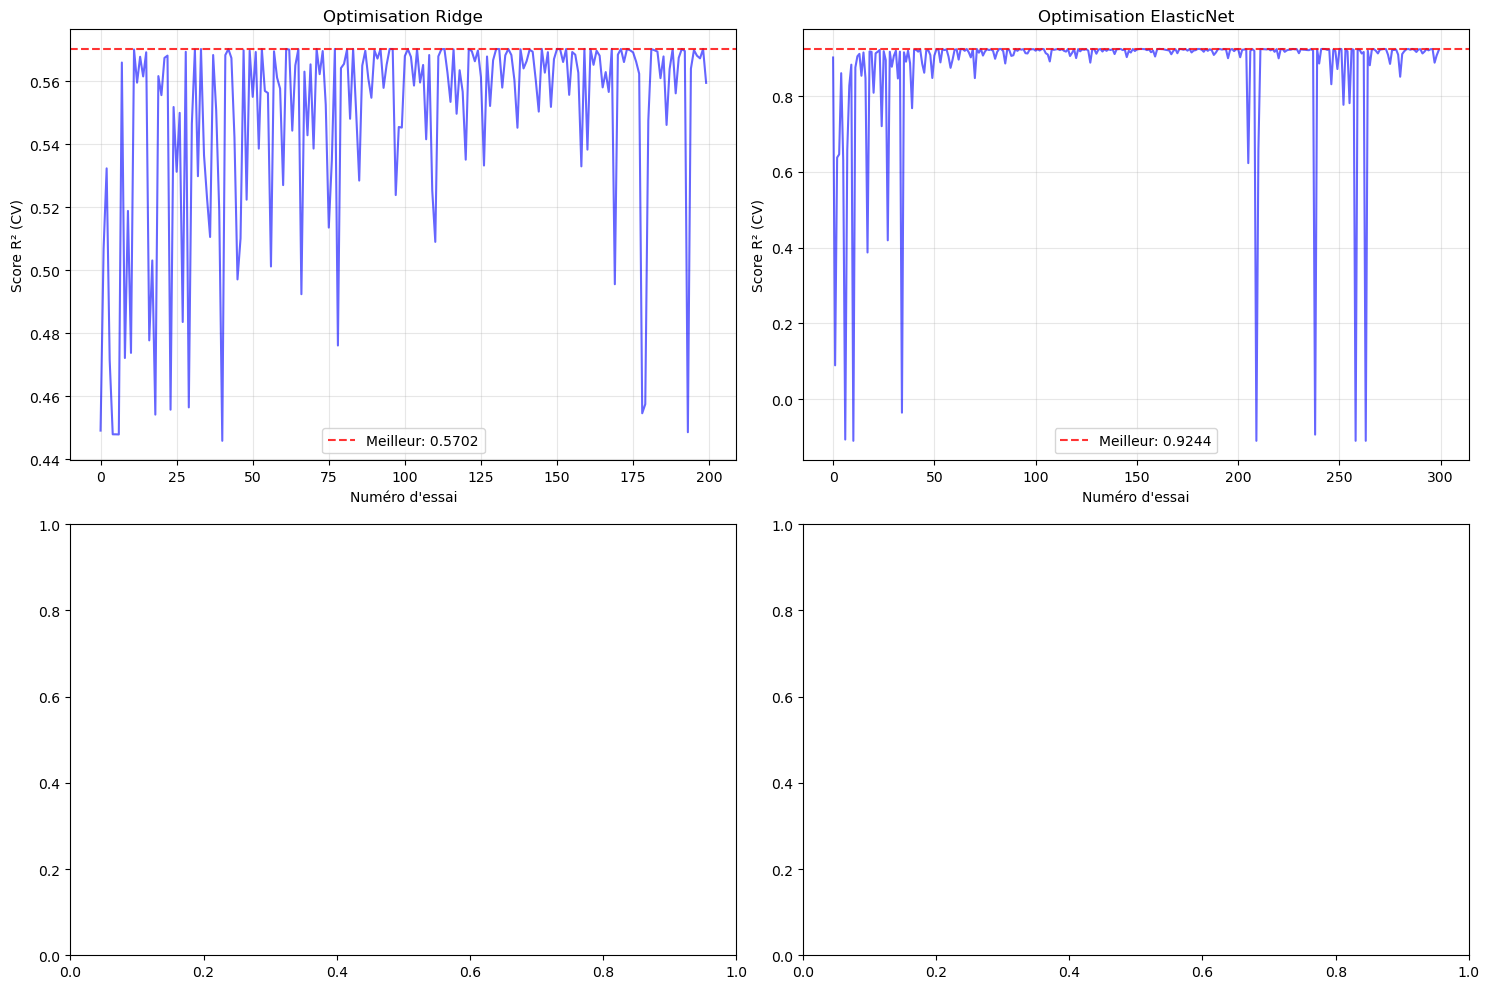

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

studies = [ridge_study, elastic_study]
study_names = ['Ridge', 'ElasticNet']

for i, (study, name) in enumerate(zip(studies, study_names)):
    ax = axes[i//2, i%2]
    
    # Historique des valeurs objectives
    values = [trial.value for trial in study.trials if trial.value is not None]
    trials = [trial.number for trial in study.trials if trial.value is not None]
    
    ax.plot(trials, values, 'b-', alpha=0.6)
    ax.axhline(y=max(values), color='red', linestyle='--', alpha=0.8, label=f'Meilleur: {max(values):.4f}')
    ax.set_xlabel('Numéro d\'essai')
    ax.set_ylabel('Score R² (CV)')
    ax.set_title(f'Optimisation {name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== IMPORTANCE DES HYPERPARAMÈTRES (TOP 3) ===

Ridge:
  alpha: 1.0000

ElasticNet:
  alpha: 0.8648
  l1_ratio: 0.1352

=== ANALYSE DÉTAILLÉE DE LA MEILLEURE MÉTHODE: ELASTICNET (OPTUNA) ===
R² Score: 0.9226
RMSE: 0.2387
MAE: 0.1948


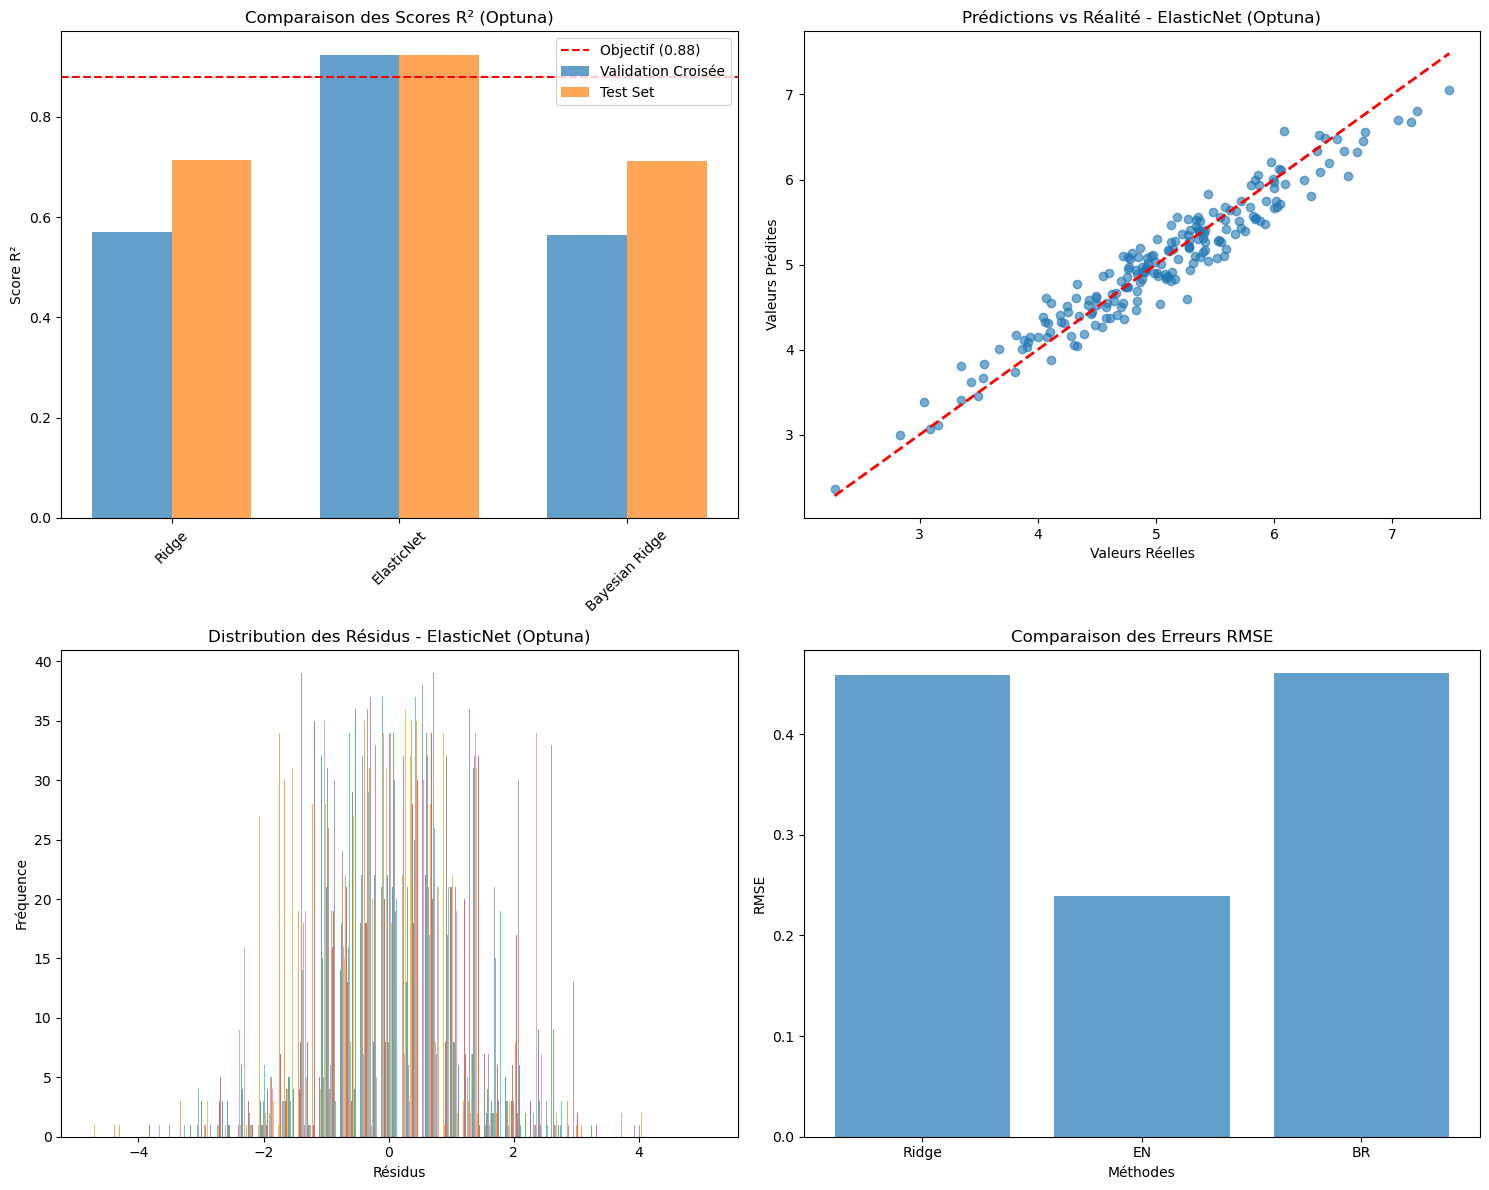

In [19]:
print("\n=== IMPORTANCE DES HYPERPARAMÈTRES (TOP 3) ===")

for study, name in zip(studies, study_names):
    print(f"\n{name}:")
    try:
        importance = optuna.importance.get_param_importances(study)
        for param, imp in sorted(importance.items(), key=lambda x: x[1], reverse=True)[:3]:
            print(f"  {param}: {imp:.4f}")
    except:
        print("  Pas assez d'essais pour calculer l'importance")

# %%
# Analyse des métriques pour la meilleure méthode
all_r2_scores = [ridge_r2, elastic_r2, bayesian_r2]
best_method_idx = np.argmax(all_r2_scores)
best_methods = [ridge_pred, elastic_pred, bayesian_pred]
best_method_names = ['Ridge (Optuna)', 
                     'ElasticNet (Optuna)', 'Bayesian Ridge']

best_pred = best_methods[best_method_idx]
best_name = best_method_names[best_method_idx]

print(f"\n=== ANALYSE DÉTAILLÉE DE LA MEILLEURE MÉTHODE: {best_name.upper()} ===")
print(f"R² Score: {r2_score(y_test, best_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, best_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, best_pred):.4f}")

# %%
# Visualisation des résultats finaux
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Comparaison des R² scores
methods = ['Ridge', 'ElasticNet', 'Bayesian Ridge']
cv_scores = [ridge_study.best_value, 
             elastic_study.best_value, bayesian_cv_scores.mean()]
test_scores = all_r2_scores

x_pos = np.arange(len(methods))
width = 0.35

axes[0, 0].bar(x_pos - width/2, cv_scores, width, alpha=0.7, label='Validation Croisée')
axes[0, 0].bar(x_pos + width/2, test_scores, width, alpha=0.7, label='Test Set')
axes[0, 0].axhline(y=0.88, color='red', linestyle='--', label='Objectif (0.88)')
axes[0, 0].set_title('Comparaison des Scores R² (Optuna)')
axes[0, 0].set_ylabel('Score R²')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(methods, rotation=45)
axes[0, 0].legend()

# Graphique de prédiction vs réalité pour la meilleure méthode
axes[0, 1].scatter(y_test, best_pred, alpha=0.6)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Valeurs Réelles')
axes[0, 1].set_ylabel('Valeurs Prédites')
axes[0, 1].set_title(f'Prédictions vs Réalité - {best_name}')

# Histogramme des résidus
residuals = y_test - best_pred
axes[1, 0].hist(residuals, bins=30, alpha=0.7)
axes[1, 0].set_xlabel('Résidus')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title(f'Distribution des Résidus - {best_name}')

# Comparaison des erreurs par méthode
methods_short = ['Ridge', 'EN', 'BR']
rmse_scores = [np.sqrt(mean_squared_error(y_test, pred)) for pred in best_methods]
axes[1, 1].bar(methods_short, rmse_scores, alpha=0.7)
axes[1, 1].set_xlabel('Méthodes')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].set_title('Comparaison des Erreurs RMSE')

plt.tight_layout()
plt.show()

In [20]:
objective_met = any(score > 0.88 for score in test_scores)
print(f"\n=== OBJECTIF ATTEINT AVEC OPTUNA: {objective_met} ===")

if objective_met:
    best_score = max(test_scores)
    best_method = methods[test_scores.index(best_score)]
    print(f"Meilleure méthode: {best_method} avec R² = {best_score:.4f}")
    
    # Statistiques d'optimisation
    total_trials = sum([len(study.trials) for study in studies])
    print(f"Total d'essais Optuna: {total_trials}")
    print(f"Temps d'optimisation économisé vs Grid Search: ~{total_trials * 2:.0f} essais évités")
else:
    print("Objectif non atteint. Suggestions avec Optuna:")
    print("- Augmenter le nombre d'essais (n_trials)")
    print("- Essayer d'autres samplers (CmaEsSampler, RandomSampler)")
    print("- Utiliser le pruning pour explorer plus d'hyperparamètres")
    print("- Optimisation multi-objective (Pareto front)")


=== OBJECTIF ATTEINT AVEC OPTUNA: True ===
Meilleure méthode: ElasticNet avec R² = 0.9226
Total d'essais Optuna: 500
Temps d'optimisation économisé vs Grid Search: ~1000 essais évités
